# Features Selection for Regression with *Feature-Engine*

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 99
import matplotlib.pyplot as plt

# LOAD DATA

In [9]:
# load data
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
data.drop(labels = ['name','boat', 'ticket','body', 'home.dest'], axis=1, inplace=True)
data = data.replace('?', np.nan)

data.dropna(subset=['embarked', 'fare'], inplace=True)
data['fare'] = data['fare'].astype('float')

data['age'] = data['age'].astype('float')
data['age'] = data['age'].fillna(data['age'].mean())

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return 'N'

data['cabin'] = data['cabin'].apply(get_first_cabin)

# extract cabin letter
data['cabin'] = data['cabin'].str[0]

# replace infrequent cabins by N
data['cabin'] = np.where(data['cabin'].isin(['T', 'G']), 'N', data['cabin'])

# cap maximum values
data['parch'] = np.where(data['parch']>3,3,data['parch'])
data['sibsp'] = np.where(data['sibsp']>3,3,data['sibsp'])

# cast variables as object to treat as categorical
data[['pclass','sibsp','parch']] = data[['pclass','sibsp','parch']].astype('O')

# display
data.shape

(1306, 9)

## DATA PREPARATION

In [10]:
# missing values imputation
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import DropMissingData
# categorical variables enconding
from feature_engine.encoding import OrdinalEncoder

In [11]:
# remove columns with to much NaN values
cols_drop = list(data.columns[(data.isnull().sum() / len(data) > 0.5).values])
data.drop(cols_drop, axis = 1, inplace = True)

In [12]:
# columns names collection by type of variable
cols_num = data.select_dtypes(include=['float64']).columns.tolist()                                       
cols_cat = data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()         
cols_int = data.select_dtypes(include=['int64']).columns.tolist()
cols_x = [c for c in cols_num + cols_cat]
col_y = "survived"
print(len(cols_num), len(cols_cat), len(cols_int))

2 6 1


In [13]:
# missing values imputation: numerical
median_imputer = MeanMedianImputer(
                   imputation_method='median',
                   variables=cols_num
                   )
data = median_imputer.fit_transform(data)
# missing values imputation: categorical
imputer = CategoricalImputer(variables=cols_cat)
data = imputer.fit_transform(data)

In [17]:
# categorical variables enconding
from feature_engine.encoding import OrdinalEncoder
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=None)
# fit the encoder
data_encoded = encoder.fit_transform(data, data[col_y])

# [FEATURES SELECTION](https://feature-engine.readthedocs.io/en/1.3.x/user_guide/selection/index.html)

In [18]:
# selection based on feature characteristics
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import DropHighPSIFeatures
# selection based on model performance
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.selection import SelectByTargetMeanPerformance
from feature_engine.selection import RecursiveFeatureElimination

### based on feature characteristics

In [19]:
# DropConstantFeatures (Allows Categorical variables, Allows NA)
fcte = DropConstantFeatures(tol=0.98, variables = cols_x, missing_values = 'ignore')
fcte.fit(data)
print(list(fcte.features_to_drop_))

[]


In [20]:
# SmartCorrelatedSelection (NOT Allows Categorical variables, Allows NA)
fcorr1 = SmartCorrelatedSelection(variables=cols_num, method='pearson', threshold=0.8, missing_values="ignore", selection_method="variance")
fcorr2 = SmartCorrelatedSelection(variables=cols_num, method='kendall', threshold=0.8, missing_values="ignore", selection_method="variance")
fcorr3 = SmartCorrelatedSelection(variables=cols_num, method='spearman', threshold=0.8, missing_values="ignore", selection_method="variance")
fcorr1.fit(data)
fcorr2.fit(data)
fcorr3.fit(data)
if len(fcorr1.features_to_drop_):
    print('pearson',fcorr1.features_to_drop_,fcorr1.correlated_feature_sets_)
if len(fcorr2.features_to_drop_):
    print('kendall',fcorr2.features_to_drop_, fcorr2.correlated_feature_sets_)
if len(fcorr3.features_to_drop_):
    print('spearman',fcorr3.features_to_drop_, fcorr3.correlated_feature_sets_)

In [23]:
# DropHighPSIFeatures (NOT Allows Categorical variables, Allows NA)
cat_ref_col = "pclass"
fpsi = DropHighPSIFeatures(variables = cols_num, split_col=cat_ref_col, split_distinct=True, missing_values="ignore")
fpsi.fit(data)
print(list(fcte.features_to_drop_))

[]


<AxesSubplot:xlabel='fare', ylabel='Proportion'>

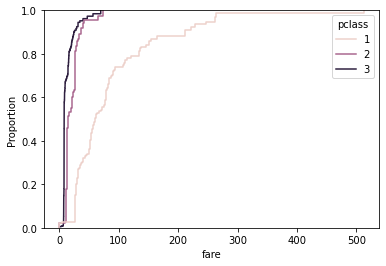

In [24]:
import seaborn as sns
sns.ecdfplot(data=data, x="fare", hue=cat_ref_col)

### selection based on model performance

In [27]:
# SelectBySingleFeaturePerformance (NOT Allows Categorical variables, NOT Allows NA)
from sklearn.linear_model import LogisticRegression
fsel1 = SelectBySingleFeaturePerformance(estimator=LogisticRegression(), scoring="roc_auc", cv=5, threshold=0.6, variables = cols_num)
fsel1.fit(data, data[col_y])
print(fsel1.features_to_drop_)

['age']


In [28]:
# SelectByTargetMeanPerformance (Allows Categorical variables, NOT Allows NA)
selcat = SelectByTargetMeanPerformance(
    variables=cols_x,
    scoring="roc_auc",
    threshold= None, # If the threshold if left to None, it selects features which performance is bigger than the mean performance of all features.
    #threshold=0.5, 
    bins=5,
    strategy="equal_frequency",
    cv=3,
    regression=False)
selcat.fit(data, data[col_y])
print(selcat.features_to_drop_)
print([c for c in cols_num if not c in list(selcat.features_to_drop_)])
print([c for c in cols_cat if not c in list(selcat.features_to_drop_)])

['age', 'pclass', 'sibsp', 'parch', 'embarked']
['fare']
['sex', 'cabin']


In [49]:
# RecursiveFeatureElimination (RFE) (NOT Allows Categorical variables, NOT Allows NA)
# NOTE: Using as estimator a tree based algorithm, it is possible categorical variables previously ordinally encoded
from sklearn.ensemble import RandomForestClassifier
tr2 = RecursiveFeatureElimination(estimator=RandomForestClassifier(), scoring="roc_auc", cv=3, variables = cols_x)
tr2.fit(data_encoded, data_encoded[col_y])
print(tr2.features_to_drop_,[c for c in cols_x if not c in list(tr2.features_to_drop_)])

['fare', 'pclass', 'cabin'] ['age', 'sex', 'sibsp', 'parch', 'embarked']


In [48]:
# RecursiveFeatureElimination (RFE) (NOT Allows Categorical variables, NOT Allows NA)
# NOTE: Using as estimator a tree based algorithm, it is possible categorical variables previously ordinally encoded
from sklearn.linear_model import LogisticRegression
tr1 = RecursiveFeatureElimination(estimator=LogisticRegression(), scoring="roc_auc", cv=3, variables = cols_x)
tr1.fit(data_encoded, data_encoded[col_y])
print(tr1.features_to_drop_,[c for c in cols_x if not c in list(tr1.features_to_drop_)])

['fare', 'sibsp', 'parch', 'cabin', 'embarked'] ['age', 'pclass', 'sex']
